In [1]:
# required libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('G:\\NLP Projects\\Sarcasm Detection\\data\\Sarcasm_Headlines_Dataset_v2.json'))

# convert to pandas dataframe
df = pd.DataFrame(data)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Preprocessing

In [3]:
labels = np.array(df.is_sarcastic)
sentences = np.array(df.headline)
print('Number of sentences and labels: ', len(labels), len(sentences))

Number of sentences and labels:  28619 28619


In [4]:
x_train, x_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)
print('Train and Test set distribution: ', len(x_train), len(x_test), len(y_train), len(y_test))

Train and Test set distribution:  22895 5724 22895 5724


In [5]:
vocab_size = 10000
max_length = 32
embedding_dim = 32
padding_type='post'
oov_token = '<OOV>'

In [6]:
# tokinizing the texts
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
#print(wored_index)

In [7]:
# pdding
train_sequences = tokenizer.texts_to_sequences(x_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

test_sequences = tokenizer.texts_to_sequences(x_test)
padded_test_sentences = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

# Model Training

In [8]:
number_of_epochs = 10
lstm1_dim = 64
lstm2_dim = 32
gru_dim = 32
filters = 128
kernel_size = 5
lr = 0.0001

In [9]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            320000    
                                                                 
 dropout (Dropout)           (None, 32, 32)            0         
                                                                 
 conv1d (Conv1D)             (None, 28, 128)           20608     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [11]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
    metrics = ['accuracy']
)

In [12]:
# raining
history = model.fit(padded_train_sequences, y_train, epochs = number_of_epochs, validation_data=(padded_test_sentences, y_test), verbose=1)

Epoch 1/10
716/716 [==============================] - 7s 8ms/step - loss: 0.6897 - accuracy: 0.5363 - val_loss: 0.6671 - val_accuracy: 0.6408
Epoch 2/10
716/716 [==============================] - 5s 7ms/step - loss: 0.5041 - accuracy: 0.7652 - val_loss: 0.4009 - val_accuracy: 0.8241
Epoch 3/10
716/716 [==============================] - 5s 8ms/step - loss: 0.3582 - accuracy: 0.8511 - val_loss: 0.3784 - val_accuracy: 0.8328
Epoch 4/10
716/716 [==============================] - 6s 8ms/step - loss: 0.3000 - accuracy: 0.8840 - val_loss: 0.3650 - val_accuracy: 0.8456
Epoch 5/10
716/716 [==============================] - 5s 8ms/step - loss: 0.2597 - accuracy: 0.9012 - val_loss: 0.3735 - val_accuracy: 0.8435
Epoch 6/10
716/716 [==============================] - 6s 8ms/step - loss: 0.2277 - accuracy: 0.9166 - val_loss: 0.3771 - val_accuracy: 0.8489
Epoch 7/10
716/716 [==============================] - 5s 8ms/step - loss: 0.2032 - accuracy: 0.9271 - val_loss: 0.3848 - val_accuracy: 0.8473
Epoch 

In [13]:
print('Accuracy on test set: ', model.evaluate(padded_test_sentences,y_test)[1]*100)

179/179 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.8431
Accuracy on test set:  84.31167006492615


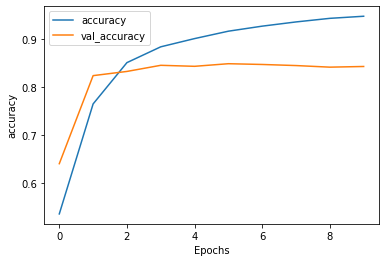

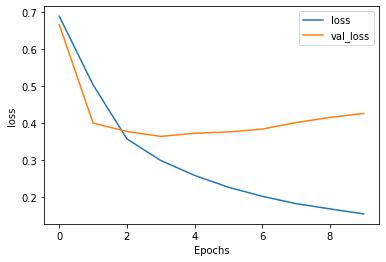

In [14]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Evaluation

In [15]:
preds = model.predict(padded_test_sentences).flatten()
y_predict = []
for i in preds:
    if i < 0.5:
        y_predict.append(0)
    else:
        y_predict.append(1)
y_predict[:5]

[0, 1, 1, 0, 0]

In [16]:
print(classification_report(y_test, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.84      0.86      0.85      2901
    Sarcastic       0.85      0.83      0.84      2823

     accuracy                           0.84      5724
    macro avg       0.84      0.84      0.84      5724
 weighted avg       0.84      0.84      0.84      5724



In [17]:
cm = confusion_matrix(y_test,y_predict)
print(cm)

[[2481  420]
 [ 478 2345]]


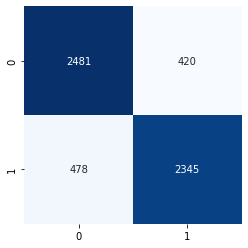

In [18]:
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);